# Deep Q-Network (DQN)

In [1]:
!pip install swig

In [2]:
!pip install tensorboard

In [3]:
!pip install stable_baselines3 'gymnasium[box2d]'

In [4]:
import gymnasium
import stable_baselines3
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.monitor import Monitor

import os
import numpy
import platform
import matplotlib
import matplotlib.pyplot
import torch
from importlib.metadata import version

In [5]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.10.16
Torch Version: 2.7.0
Is Cuda Available: True
Cuda Version: 12.6
Gymnasium Version: 1.1.1
Numpy Version: 2.0.1
Scipy Version: 1.15.3
Swig Version: 4.3.1
Stable Baselines3 Version: 2.6.0
IPython Version: 8.30.0


In [6]:
env = gymnasium.make('CarRacing-v3', continuous=False)
print("Observation Space Size: ", env.observation_space)
print("Action Space Size: ", env.action_space)
env.close()

Observation Space Size:  Box(0, 255, (96, 96, 3), uint8)
Action Space Size:  Discrete(5)


In [7]:
env_str = "CarRacing-v3"
log_dir = "./logs/{}".format(env_str)
env_kwargs_dict={"continuous": False}
gray_scale = True

# If gray_scale True, convert obs to gray scale 84 x 84 image
wrapper_class = WarpFrame if gray_scale else None

In [9]:
def make_env():
    env = gym.make(env_str, **env_kwargs_dict)
    env = wrapper_class(env)
    return Monitor(env)


# Create Training CarRacing environment
env = make_vec_env(env_str,
                   n_envs=4,
                   env_kwargs=env_kwargs_dict,
                   wrapper_class=wrapper_class)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Create Evaluation CarRacing environment
env_val = make_vec_env(env_str,
                       n_envs=4,
                       env_kwargs=env_kwargs_dict,
                       wrapper_class=wrapper_class)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             n_eval_episodes=20)

# Initialize DQN
# buffer_size - encourages exploration of other actions
model = DQN('CnnPolicy',
            env,
            # gamma=0.999,
            # train_freq=16,
            verbose=0,
            tensorboard_log=os.path.join(log_dir, "dqn_car_racing"),
            # learning_rate=1e-4, 
            buffer_size=150_000,
            # target_update_interval=5000,
            # batch_size=16,
            # exploration_fraction=0.01,
            # exploration_final_eps=0.01,
           )

class TensorboardCallback(BaseCallback):
    def _on_step(self) -> bool:
        # La recompensa promedio del rollout
        if self.n_calls % 100 == 0:
            self.logger.record("custom/epsilon", self.model.exploration_rate)
        return True

all_callbacks = CallbackList([eval_callback, TensorboardCallback()])

# Train the model
# first entraning stepts equal to 750_000
# second try entraning with 500_000 steps
model.learn(total_timesteps=750_000, 
            progress_bar=True,
            log_interval=100,
            callback=all_callbacks)

# Save the model
model.save(os.path.join(log_dir, "dqn_car_racing"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=100000, episode_reward=-44.76 +/- 39.43

Episode length: 361.30 +/- 44.11

New best mean reward!

Eval num_timesteps=200000, episode_reward=64.62 +/- 30.73

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=300000, episode_reward=-61.20 +/- 52.53

Episode length: 569.05 +/- 133.84

Eval num_timesteps=400000, episode_reward=464.70 +/- 100.75

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=500000, episode_reward=636.54 +/- 67.64

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=600000, episode_reward=334.89 +/- 207.62

Episode length: 898.85 +/- 157.27

Eval num_timesteps=700000, episode_reward=756.89 +/- 73.44

Episode length: 999.25 +/- 3.27

New best mean reward!

Mean reward: 467.30 +/- 263.74


In [8]:
# Create Evaluation CarRacing environment
env = make_vec_env(env_str,
                   n_envs=1,
                   seed=0,
                   env_kwargs=env_kwargs_dict,
                   wrapper_class=wrapper_class)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = DQN.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/",
                       video_length=10000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_car_racing_dqn")

obs = env.reset()
for _ in range(10000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: 722.73 +/- 66.34
Moviepy - Building video /home/kevin/Documents/projects/Car/AutonomousRacing/Workshop-3/car_racing/videos/best_model_car_racing_dqn-step-0-to-step-10000.mp4.
Moviepy - Writing video /home/kevin/Documents/projects/Car/AutonomousRacing/Workshop-3/car_racing/videos/best_model_car_racing_dqn-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /home/kevin/Documents/projects/Car/AutonomousRacing/Workshop-3/car_racing/videos/best_model_car_racing_dqn-step-0-to-step-10000.mp4


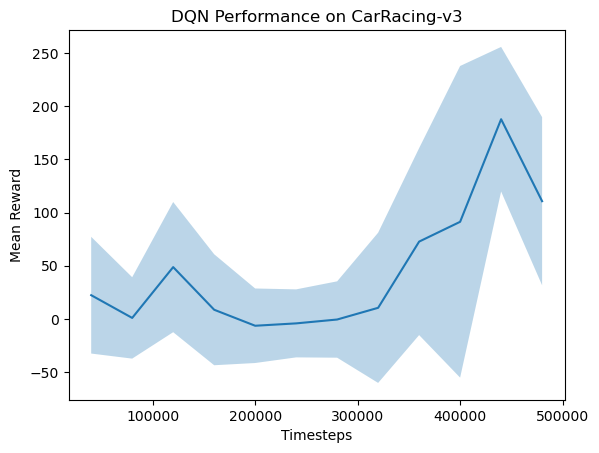

In [14]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel("Timesteps")
matplotlib.pyplot.ylabel("Mean Reward")
matplotlib.pyplot.title(f"DQN Performance on {env_str}")
matplotlib.pyplot.show()